# Example Exam Problem

## Download the dataset

In [1]:
!gdown 1dx2Hw8873hJ1nZIgnDxwjqXezYUb3jSP
!gdown 12oMFU-mFRbndrHRAWhsW6vNqTHIaSjY7

Downloading...
From: https://drive.google.com/uc?id=1dx2Hw8873hJ1nZIgnDxwjqXezYUb3jSP
To: /content/DJIA_table.csv
100% 167k/167k [00:00<00:00, 77.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=12oMFU-mFRbndrHRAWhsW6vNqTHIaSjY7
To: /content/RedditNews.csv
100% 9.10M/9.10M [00:00<00:00, 58.1MB/s]


We have stock price data and relevant news headlines for the stock. The task is to combine both types of data in order to implement a multimodal forcasting model for the 'close' price of the Dow Jones Industrial Average Index.

In [57]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Input, Dense, LSTM, Embedding, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
stock_data = pd.read_csv('DJIA_table.csv')

In [4]:
stock_data

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234
...,...,...,...,...,...,...,...
1984,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688
1985,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
1986,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
1987,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609


Set the date as index to be sure that the rows are in the right order

In [5]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data.set_index('Date')

In [6]:
news_data = pd.read_csv('RedditNews.csv')

In [7]:
news_data['Date'] = pd.to_datetime(news_data['Date'])
news_data = news_data.set_index('Date')

In [8]:
news_data

,News
Date,
2016-07-01,A 117-year-old woman in Mexico City finally re...
2016-07-01,IMF chief backs Athens as permanent Olympic host
2016-07-01,"The president of France says if Brexit won, so..."
2016-07-01,British Man Who Must Give Police 24 Hours' Not...
2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...
...,...
2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...
2008-06-08,b'Threat of world AIDS pandemic among heterose...
2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...


Merge the two datasets based on the date (index)

In [9]:
data = stock_data.merge(news_data, how='left', right_index=True, left_index=True)

In [10]:
data

,Open,High,Low,Close,Volume,Adj Close,News
Date,,,,,,,
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,"b""Georgia 'downs two Russian warplanes' as cou..."
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,b'BREAKING: Musharraf to be impeached.'
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,b'Russia Today: Columns of troops roll into So...
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,b'Russian tanks are moving towards the capital...
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,"b""Afghan children raped with 'impunity,' U.N. ..."
...,...,...,...,...,...,...,...
2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,Philippines president Rodrigo Duterte urges pe...
2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,Spain arrests three Pakistanis accused of prom...
2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,"Venezuela, where anger over food shortages is ..."


We have multiple news headlines for each date. We need to combine them in some way to get a single row per date.

We will perform an aggregation where we group by the date column and join all of the news data into one single string, separating them with \n character.

We will only keep one value for the price attributes since they will be the same in all rows representing the same date

In [11]:
data.columns[:-1]

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [12]:
aggregation = {
    col: 'first' for col in data.columns[:-1]
}
aggregation.update({'News': '\n'.join})

In [13]:
aggregation

{'Open': 'first',
 'High': 'first',
 'Low': 'first',
 'Close': 'first',
 'Volume': 'first',
 'Adj Close': 'first',
 'News': <function str.join(iterable, /)>}

Group by date and aggregate

In [14]:
data = data.groupby('Date').agg(aggregation)

In [15]:
data

,Open,High,Low,Close,Volume,Adj Close,News
Date,,,,,,,
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,"b""Georgia 'downs two Russian warplanes' as cou..."
2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,b'Why wont America and Nato help us? If they w...
2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,b'Remember that adorable 9-year-old who sang a...
2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,b' U.S. refuses Israel weapons to attack Iran:...
2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,b'All the experts admit that we should legalis...
...,...,...,...,...,...,...,...
2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,Barclays and RBS shares suspended from trading...
2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,"2,500 Scientists To Australia: If You Want To ..."
2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,Explosion At Airport In Istanbul\nYemeni forme...


Get the news from the previous day as features to forecast the close price for the following day

In [16]:
data['News_yesterday'] = data.News.shift()

In [17]:
data

,Open,High,Low,Close,Volume,Adj Close,News,News_yesterday
Date,,,,,,,,
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,"b""Georgia 'downs two Russian warplanes' as cou...",None
2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,b'Why wont America and Nato help us? If they w...,"b""Georgia 'downs two Russian warplanes' as cou..."
2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,b'Remember that adorable 9-year-old who sang a...,b'Why wont America and Nato help us? If they w...
2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,b' U.S. refuses Israel weapons to attack Iran:...,b'Remember that adorable 9-year-old who sang a...
2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,b'All the experts admit that we should legalis...,b' U.S. refuses Israel weapons to attack Iran:...
...,...,...,...,...,...,...,...,...
2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,Barclays and RBS shares suspended from trading...,David Cameron to Resign as PM After EU Referen...
2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,"2,500 Scientists To Australia: If You Want To ...",Barclays and RBS shares suspended from trading...
2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,Explosion At Airport In Istanbul\nYemeni forme...,"2,500 Scientists To Australia: If You Want To ..."


In [18]:
data.columns[:-2]

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [19]:
numeric_feature_names = data.columns[:-2]

In [20]:
lags = 5

Create lags for the 5 previous days for each numeric column and use them as features for predicting the close price

In [21]:
for i in range(1, lags + 1):
  for col in numeric_feature_names:
    data[f'{col}_lag_{i}'] = data[col].shift(i)

In [22]:
data

,Open,High,Low,Close,Volume,Adj Close,News,News_yesterday,Open_lag_1,High_lag_1,...,Low_lag_4,Close_lag_4,Volume_lag_4,Adj Close_lag_4,Open_lag_5,High_lag_5,Low_lag_5,Close_lag_5,Volume_lag_5,Adj Close_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,"b""Georgia 'downs two Russian warplanes' as cou...",None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,b'Why wont America and Nato help us? If they w...,"b""Georgia 'downs two Russian warplanes' as cou...",11432.089844,11759.959961,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,b'Remember that adorable 9-year-old who sang a...,b'Why wont America and Nato help us? If they w...,11729.669922,11867.110352,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,b' U.S. refuses Israel weapons to attack Iran:...,b'Remember that adorable 9-year-old who sang a...,11781.700195,11782.349609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,b'All the experts admit that we should legalis...,b' U.S. refuses Israel weapons to attack Iran:...,11632.809570,11633.780273,...,11388.040039,11734.320312,212830000.0,11734.320312,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,Barclays and RBS shares suspended from trading...,David Cameron to Resign as PM After EU Referen...,17946.630859,17946.630859,...,17799.800781,17829.730469,85130000.0,17829.730469,17736.869141,17946.359375,17736.869141,17804.869141,99380000.0,17804.869141
2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,"2,500 Scientists To Australia: If You Want To ...",Barclays and RBS shares suspended from trading...,17355.210938,17355.210938,...,17770.359375,17780.830078,89440000.0,17780.830078,17827.330078,17877.839844,17799.800781,17829.730469,85130000.0,17829.730469
2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,Explosion At Airport In Istanbul\nYemeni forme...,"2,500 Scientists To Australia: If You Want To ...",17190.509766,17409.720703,...,17844.109375,18011.070312,98070000.0,18011.070312,17832.669922,17920.160156,17770.359375,17780.830078,89440000.0,17780.830078


In [23]:
data = data.dropna(axis=0)

In [24]:
numeric_feature_names = data.columns[8:]  # get the numeric columns

In [25]:
text_feature_names = 'News_yesterday'  # this is the only text column that we can use

In [26]:
target = 'Close'

Separate features to perform different preprocessing

In [27]:
numeric_features = data[numeric_feature_names]
text_features = data[text_feature_names]

In [28]:
numeric_features

,Open_lag_1,High_lag_1,Low_lag_1,Close_lag_1,Volume_lag_1,Adj Close_lag_1,Open_lag_2,High_lag_2,Low_lag_2,Close_lag_2,...,Low_lag_4,Close_lag_4,Volume_lag_4,Adj Close_lag_4,Open_lag_5,High_lag_5,Low_lag_5,Close_lag_5,Volume_lag_5,Adj Close_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-15,11532.070312,11718.280273,11450.889648,11615.929688,159790000.0,11615.929688,11632.809570,11633.780273,11453.339844,11532.959961,...,11675.530273,11782.349609,183190000.0,11782.349609,11432.089844,11759.959961,11388.040039,11734.320312,212830000.0,11734.320312
2008-08-18,11611.209961,11709.889648,11599.730469,11659.900391,215040000.0,11659.900391,11532.070312,11718.280273,11450.889648,11615.929688,...,11601.519531,11642.469727,173590000.0,11642.469727,11729.669922,11867.110352,11675.530273,11782.349609,183190000.0,11782.349609
2008-08-19,11659.650391,11690.429688,11434.120117,11479.389648,156290000.0,11479.389648,11611.209961,11709.889648,11599.730469,11659.900391,...,11453.339844,11532.959961,182550000.0,11532.959961,11781.700195,11782.349609,11601.519531,11642.469727,173590000.0,11642.469727
2008-08-20,11478.089844,11478.169922,11318.500000,11348.549805,171580000.0,11348.549805,11659.650391,11690.429688,11434.120117,11479.389648,...,11450.889648,11615.929688,159790000.0,11615.929688,11632.809570,11633.780273,11453.339844,11532.959961,182550000.0,11532.959961
2008-08-21,11345.940430,11454.150391,11290.580078,11417.429688,144880000.0,11417.429688,11478.089844,11478.169922,11318.500000,11348.549805,...,11599.730469,11659.900391,215040000.0,11659.900391,11532.070312,11718.280273,11450.889648,11615.929688,159790000.0,11615.929688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-27,17946.630859,17946.630859,17356.339844,17400.750000,239000000.0,17400.750000,17844.109375,18011.070312,17844.109375,18011.070312,...,17799.800781,17829.730469,85130000.0,17829.730469,17736.869141,17946.359375,17736.869141,17804.869141,99380000.0,17804.869141
2016-06-28,17355.210938,17355.210938,17063.080078,17140.240234,138740000.0,17140.240234,17946.630859,17946.630859,17356.339844,17400.750000,...,17770.359375,17780.830078,89440000.0,17780.830078,17827.330078,17877.839844,17799.800781,17829.730469,85130000.0,17829.730469
2016-06-29,17190.509766,17409.720703,17190.509766,17409.720703,112190000.0,17409.720703,17355.210938,17355.210938,17063.080078,17140.240234,...,17844.109375,18011.070312,98070000.0,18011.070312,17832.669922,17920.160156,17770.359375,17780.830078,89440000.0,17780.830078


In [29]:
text_features

Date
2008-08-15    b'All the experts admit that we should legalis...
2008-08-18    b"Mom of missing gay man: Too bad he's not a 2...
2008-08-19    b'In an Afghan prison, the majority of female ...
2008-08-20    b"Man arrested and locked up for five hours af...
2008-08-21    b'Two elderly Chinese women have been sentence...
                                    ...                        
2016-06-27    David Cameron to Resign as PM After EU Referen...
2016-06-28    Barclays and RBS shares suspended from trading...
2016-06-29    2,500 Scientists To Australia: If You Want To ...
2016-06-30    Explosion At Airport In Istanbul\nYemeni forme...
2016-07-01    Jamaica proposes marijuana dispensers for tour...
Name: News_yesterday, Length: 1984, dtype: object

In [30]:
Y = data[target]

In [31]:
Y

Date
2008-08-15    11659.900391
2008-08-18    11479.389648
2008-08-19    11348.549805
2008-08-20    11417.429688
2008-08-21    11430.209961
                  ...     
2016-06-27    17140.240234
2016-06-28    17409.720703
2016-06-29    17694.679688
2016-06-30    17929.990234
2016-07-01    17949.369141
Name: Close, Length: 1984, dtype: float64

Split the features into training and testing subsets (set shuffle to False since it's time-series data)

In [32]:
X_train_numeric, X_test_numeric, Y_train, Y_test = train_test_split(numeric_features, Y, shuffle=False, test_size=0.2)

In [33]:
X_train_text, X_test_text, _, _ = train_test_split(text_features, Y, shuffle=False, test_size=0.2)

Scale the numeric features with MinMaxScaler to help network convergence and avoid overfitting

In [34]:
scaler = MinMaxScaler()
X_train_numeric = scaler.fit_transform(X_train_numeric)
X_test_numeric = scaler.transform(X_test_numeric)
Y_train = scaler.fit_transform(Y_train.values.reshape(-1, 1))

Tokenize texts and create padded sequences of same length as features for the news headlines

In [35]:
max_words = 1000

In [36]:
tokenizer = Tokenizer(max_words)
tokenizer.fit_on_texts(X_train_text.values)
X_train_text = tokenizer.texts_to_sequences(X_train_text.values)
X_test_text = tokenizer.texts_to_sequences(X_test_text.values)
X_train_text = pad_sequences(X_train_text, 64)
X_test_text = pad_sequences(X_test_text, 64)

## Approach 1: Dense network with concatenated features


Easier but less accurate

Transform the lists to arrays in order to concatenate them

In [37]:
X_train_text = np.array([np.array(encoding) for encoding in X_train_text])
X_test_text = np.array([np.array(encoding) for encoding in X_test_text])

In [38]:
X_train = np.concatenate([X_train_numeric, X_train_text], axis=1)
X_test = np.concatenate([X_test_numeric, X_test_text], axis=1)

Create a basic dense network with both types of features combined as input

In [39]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

In [40]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanAbsoluteError()])

In [41]:
history = model.fit(X_train, Y_train, validation_split=0.2, shuffle=False, epochs=50, batch_size=16)

Epoch 1/50
80/80 [==============================] - 2s 6ms/step - loss: 1662.5227 - mean_absolute_error: 22.0096 - val_loss: 53.7901 - val_mean_absolute_error: 4.6169
Epoch 2/50
80/80 [==============================] - 0s 3ms/step - loss: 35.2270 - mean_absolute_error: 3.3511 - val_loss: 11.4055 - val_mean_absolute_error: 1.9887
Epoch 3/50
80/80 [==============================] - 0s 3ms/step - loss: 9.6372 - mean_absolute_error: 1.6052 - val_loss: 5.0741 - val_mean_absolute_error: 1.3352
Epoch 4/50
80/80 [==============================] - 0s 3ms/step - loss: 4.1889 - mean_absolute_error: 1.0323 - val_loss: 3.1103 - val_mean_absolute_error: 1.1200
Epoch 5/50
80/80 [==============================] - 0s 3ms/step - loss: 2.4212 - mean_absolute_error: 0.7989 - val_loss: 2.3426 - val_mean_absolute_error: 1.0333
Epoch 6/50
80/80 [==============================] - 0s 3ms/step - loss: 1.6184 - mean_absolute_error: 0.6875 - val_loss: 1.9183 - val_mean_absolute_error: 0.9769
Epoch 7/50
80/80 [===

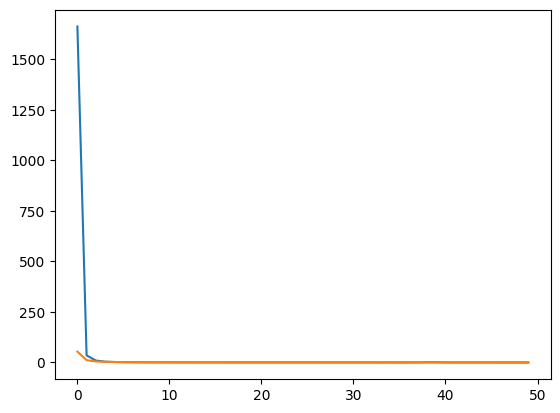

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [43]:
preds = model.predict(X_test)

13/13 [==============================] - 0s 2ms/step


In [44]:
preds = scaler.inverse_transform(preds)

In [45]:
preds[preds < 0 ]

array([-7454.238], dtype=float32)

In [46]:
preds[preds < 0] = 0

In [47]:
mean_squared_error(Y_test, preds), mean_absolute_error(Y_test, preds), r2_score(Y_test, preds)

(94085447.43514219, 7911.4884190129105, -245.10971133838459)

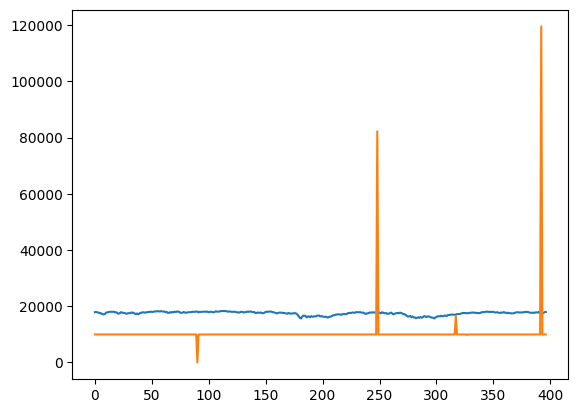

In [48]:
plt.plot(Y_test.values)
plt.plot(preds)
plt.show()

## Approach 2: Embedding layer for texts with LSTM for lags

Reshape numeric features to [num_samples, num_timesteps, num_features] for training an LSTM layer

In [51]:
X_train_numeric = X_train_numeric.reshape(-1, lags, len(X_train_numeric[0]) // lags)

In [52]:
X_train_numeric.shape

(1587, 5, 6)

Create input for lstm layer. Here we add an input layer which will get only the numeric part of the dataset. This input layer is then passed into the LSTM to create feature transformations for the numeric data only.

In [53]:
numerical_input = Input(shape=(X_train_numeric.shape[1], X_train_numeric.shape[2]), name='numerical_input')
numerical_output = LSTM(64, activation='relu')(numerical_input)

Create input for embedding layer. The input will then be passed to an embedding layer whihc will transform vocabulary indices into continuous vector representations. This output will then be passed to an LSTM layer to learn positional dependence of the words in the sentences

In [54]:
textual_input = Input(shape=(64,), name='textual_input')
textual_output = Embedding(input_dim=max_words, output_dim=32, input_length=64)(textual_input)
textual_output = LSTM(64)(textual_output)

Create a concatenation layer which will then combine the input and output of the two separate sequences into one vector. We will pass this as a join representation to a hidden dense layer, and finally to a dense layer with a single neuron to represent the output (close price).

In [56]:
merged_output = concatenate([numerical_output, textual_output])
merged_output = Dense(32, activation='relu')(merged_output)
output = Dense(1, activation='linear', name='output')(merged_output)

In [68]:
model = Model(inputs=[numerical_input, textual_input], outputs=output)

In [69]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanAbsoluteError()])

When fitting the model we need to pass the feature groups as separate elements in a list.

In [70]:
history = model.fit([X_train_numeric, X_train_text], Y_train, validation_split=0.2, shuffle=False, batch_size=16, epochs=10)

Epoch 1/10
80/80 [==============================] - 9s 50ms/step - loss: 3.3922e-04 - mean_absolute_error: 0.0140 - val_loss: 6.9496e-04 - val_mean_absolute_error: 0.0213
Epoch 2/10
80/80 [==============================] - 4s 54ms/step - loss: 5.1798e-04 - mean_absolute_error: 0.0180 - val_loss: 0.0017 - val_mean_absolute_error: 0.0355
Epoch 3/10
80/80 [==============================] - 3s 37ms/step - loss: 3.3170e-04 - mean_absolute_error: 0.0147 - val_loss: 7.2032e-04 - val_mean_absolute_error: 0.0220
Epoch 4/10
80/80 [==============================] - 4s 49ms/step - loss: 5.7705e-04 - mean_absolute_error: 0.0204 - val_loss: 0.0024 - val_mean_absolute_error: 0.0420
Epoch 5/10
80/80 [==============================] - 3s 35ms/step - loss: 0.0015 - mean_absolute_error: 0.0326 - val_loss: 0.0012 - val_mean_absolute_error: 0.0280
Epoch 6/10
80/80 [==============================] - 4s 52ms/step - loss: 0.0013 - mean_absolute_error: 0.0293 - val_loss: 0.0018 - val_mean_absolute_error: 0.035

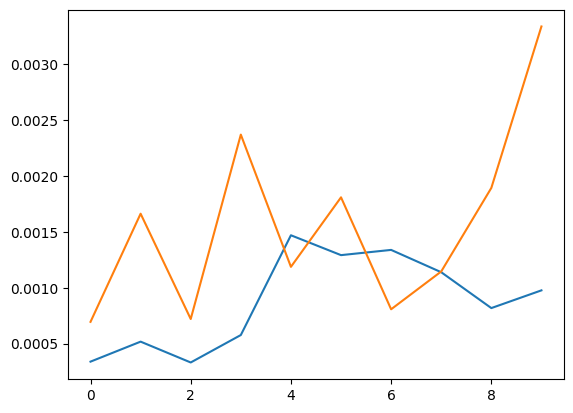

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [76]:
X_test_numeric = X_test_numeric.reshape(-1, lags, len(X_test_numeric[0]) // lags)

In [77]:
preds = model.predict([X_test_numeric, X_test_text])

13/13 [==============================] - 1s 12ms/step


In [78]:
preds = scaler.inverse_transform(preds)

In [79]:
preds[preds < 0 ]

array([], dtype=float32)

In [80]:
preds[preds < 0] = 0

In [81]:
mean_squared_error(Y_test, preds), mean_absolute_error(Y_test, preds), r2_score(Y_test, preds)

(394855.4440919877, 528.6212806914359, -0.03286705877503793)

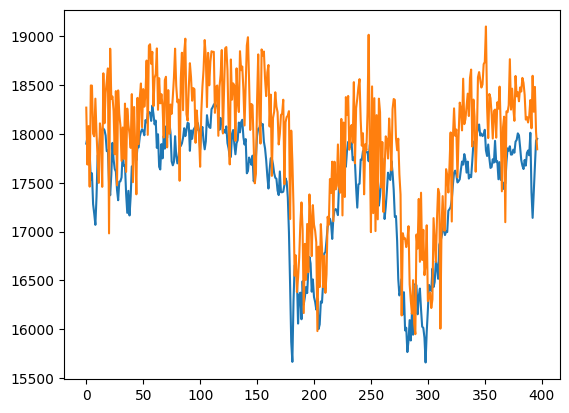

In [82]:
plt.plot(Y_test.values)
plt.plot(preds)
plt.show()

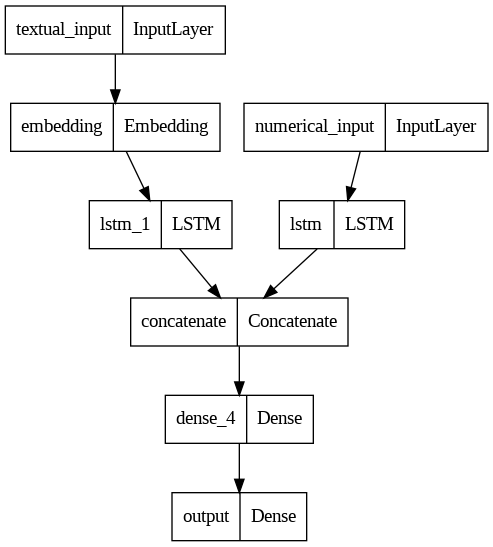

In [84]:
keras.utils.plot_model(model)

In [86]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 textual_input (InputLayer)  [(None, 64)]                 0         []                            
                                                                                                  
 numerical_input (InputLaye  [(None, 5, 6)]               0         []                            
 r)                                                                                               
                                                                                                  
 embedding (Embedding)       (None, 64, 32)               32000     ['textual_input[0][0]']       
                                                                                                  
 lstm (LSTM)                 (None, 64)                   18176     ['numerical_input[0][0]'